# **Table of Contents**
* [Data Wrangling](#section_21)<br><br>
* [Discovering Clusters](#section_2)
    * [Finding best 'K'](#section_3)
    * [Using best 'K'](#section_4)
    * [Cluster labelling](#section_5)
    * [Viewing Clusters](#section_6)<br><br>
* [Inference from Clusters](#section_7)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df  = pd.read_csv ("datasets/Wine.csv")

df.sample(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
218,7.5,0.49,0.19,1.9,0.076,10.0,44.0,0.99570,3.39,0.54,9.7,5
255,8.0,0.57,0.23,3.2,0.073,17.0,119.0,0.99675,3.26,0.57,9.3,5
1225,9.2,0.46,0.23,2.6,0.091,18.0,77.0,0.99922,3.15,0.51,9.4,5


<a id='section_21'></a>
# **1 - Data Wrangling**

## **1.1 - Feature Selection via SelectKBest**

In [3]:
X  =  df.drop('quality',axis=1)                                    
Y  =  df ['quality']

In [4]:
from   sklearn.feature_selection   import   SelectKBest , f_classif

skb = SelectKBest ( f_classif , k=11 )                                             #  k = number of features

skb.fit_transform (X,Y)

skb.pvalues_

array([8.79396662e-006, 3.32646506e-058, 4.42109157e-019, 3.84618775e-001,
       1.52653902e-005, 2.57082723e-004, 8.53359845e-025, 8.12439442e-013,
       6.28438870e-004, 1.22589009e-021, 1.20989516e-104])

#### **Inference**
* Best predictors ---- volatile_acidity , citric_acid , total_sulfur_dioxide , density , sulphates , alcohol
* Avg  predictors ---- fixed_acidity , chlorides , free_sulfur_dioxide , pH
* Worst predictors ---- residual_sugar

## **1.2 - Drop**

* Hence dropping Worst significant columns

In [5]:
df.drop ( ['residual_sugar','free_sulfur_dioxide','pH','fixed_acidity','chlorides'] , axis=1 , inplace =True )   

* Dropping target column for clustering perspective

In [6]:
df.drop ( 'quality' , axis=1 , inplace =True )                     

## **1.3 - Transform**

In [7]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

In [8]:
df = pd.DataFrame ( pt.fit_transform(df)  ,  columns = df.columns )

df.head(3)

,volatile_acidity,citric_acid,total_sulfur_dioxide,density,sulphates,alcohol
0,0.995542,-1.531109,-0.124411,0.564442,-0.581650,-1.075025
1,1.771299,-1.531109,0.854954,0.036966,0.395140,-0.500860
2,1.269801,-1.255359,0.540394,0.142851,0.183772,-0.500860


<a id='section_2'></a>
# **2 - Discovering Clusters** 

<a id='section_3'></a>
## **2.1 - Finding Best K**

### **2.1.1 - Pairplot**

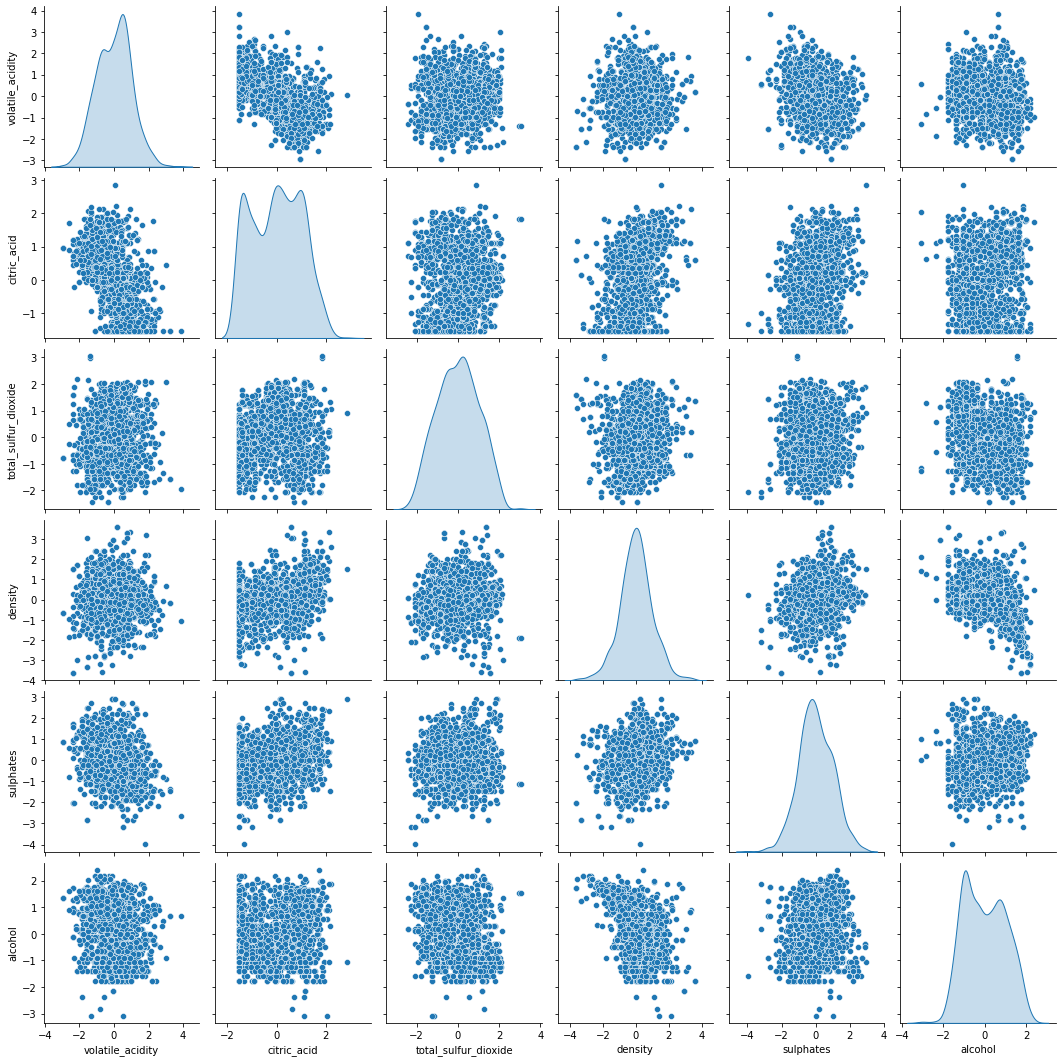

In [9]:
sns.pairplot ( df , diag_kind ='kde' ) ;

#### **Inference**
* Range of K = 2 to 7

### **2.1.2 - Elbow Plot**

In [10]:
from sklearn.cluster import KMeans

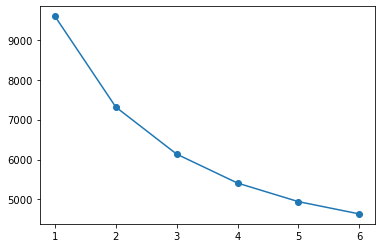

In [11]:
err    = []                      # wcss (within cluster sum square)     # inertia       # total spread

for k in range(1,7):
    
    KM  =  KMeans ( k , n_init =5 , max_iter =1000 , random_state =2 )
    KM.fit(df)            
    err.append    ( KM.inertia_  ) 
    
    
plt.plot  ( range(1,7)  , err  , marker='o') ;

### **2.1.3 - Silhouette Score**

In [12]:
from   sklearn.metrics   import   silhouette_score

In [13]:
scores =[]

for k in range(2,7):                                                               

    KM     =  KMeans (n_clusters =k , random_state =2)
    
    labels =  KM.fit_predict (df)

    avg    =  silhouette_score ( df , labels)
    
    scores.append ( {'k':k , 'Avg Silhouette Score':avg} )

In [14]:
table = pd.DataFrame (scores)

table.sort_values ( 'Avg Silhouette Score' , ascending=0)    .head()    .style.hide_index()

k,Avg Silhouette Score
2,0.232074
3,0.206562
4,0.189623
5,0.183286
6,0.182674


### **2.1.4 - Dendrogram**

In [15]:
from sklearn.cluster          import  AgglomerativeClustering 
from scipy.cluster.hierarchy  import  dendrogram, linkage

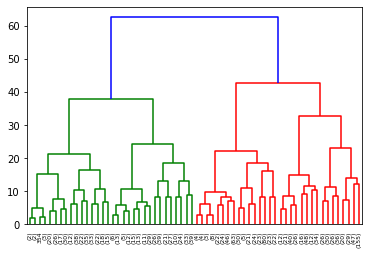

In [16]:
model  =  AgglomerativeClustering  ( affinity ='euclidean' ,  linkage ='ward' )

model.fit (df)

Z = linkage (df, 'ward')

dendrogram ( Z  ,  p=5  ,  truncate_mode='level')                                                   

plt.show()

<a id='section_4'></a>
## **2.2 - Using best K**

| Method | Best K |
| ---    | ---    |
| Elbow  | 2 |         
| Silhouette | 2 |
| Dendrogram | 2|

In [17]:
KM    =  KMeans ( n_clusters=2 )  .fit (df)     

<a id='section_5'></a>
## **2.3 - Cluster labelling of records**

In [18]:
labels        =  KM.predict (df)                                   

df["cluster"] =  labels

<a id='section_6'></a>
## **2.4 - Viewing Clusters**

### **2.4.1 - Pairplot**

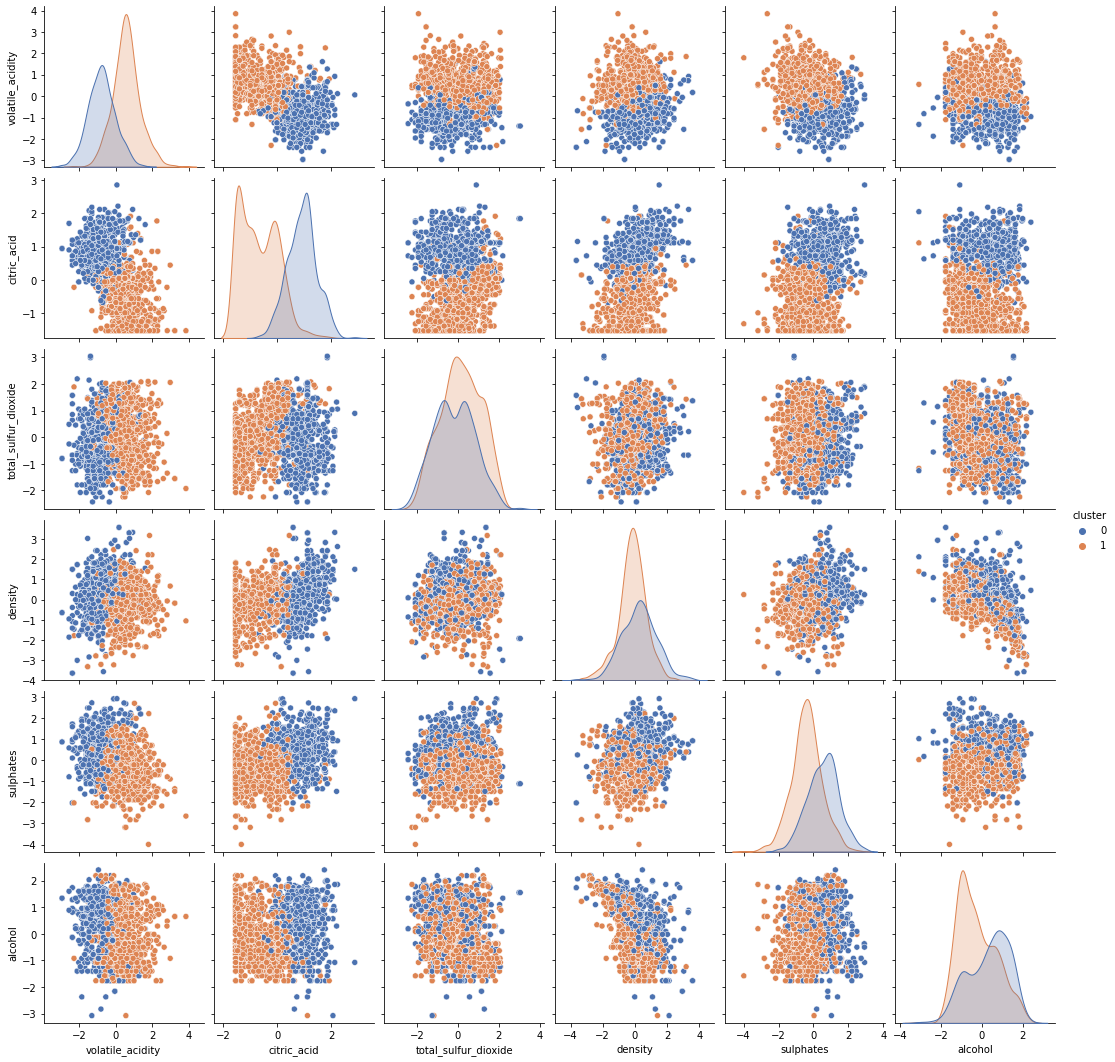

In [19]:
sns.pairplot ( df , diag_kind ='kde' , hue='cluster' , palette='deep') ;

### **2.4.2 - Boxplot**

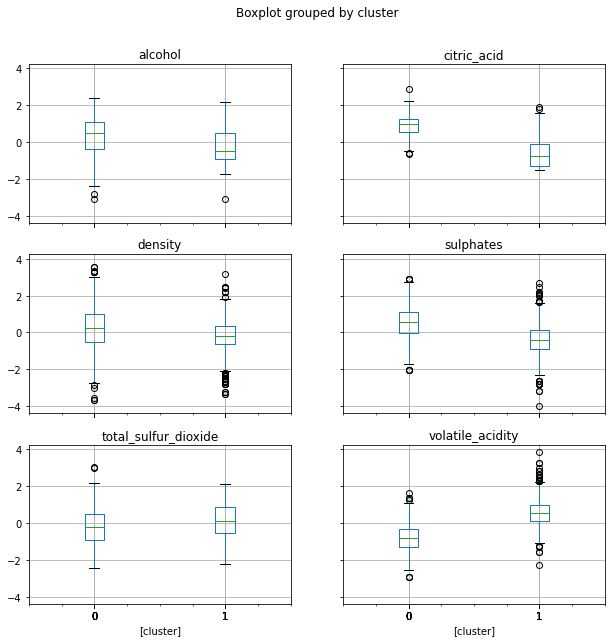

In [20]:
df.boxplot (by='cluster', figsize=(10,10))

plt.show()

### **2.4.3 Scatterplot**

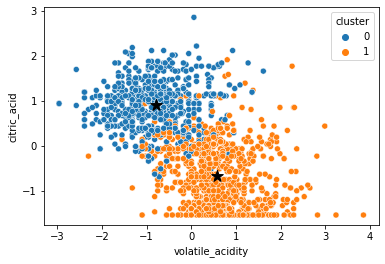

In [21]:
sns.scatterplot ( x='volatile_acidity' ,  y='citric_acid'  ,  hue = 'cluster' , data=df )  

plt.scatter ( x = KM.cluster_centers_[:, 0] , y = KM.cluster_centers_[:, 1] , s=150 , c='black' , marker='*' )

plt.show()

<a id='section_7'></a>
# **3 - Inference from Clusters**

| Label | Signifies |
| ---    | ---    |
| 0 | High quality wine |         
| 1 | Low quality wine |